Source:
https://github.com/jeffheaton/app_deep_learning/blob/main/t81_558_class_04_4_batch_norm.ipynb

### Batch Normalization
We are going to take a deep dive into and advanced concept in training neural networks known as Batch Normalization. The goal of batch normalization is to accelerate learning and stabilize the learning process. The same dataset used previously in this chapter. To implement batch normalization we will modify both preprocessing and a neural network setup. The original preprocessing method used a z-score standardization to make the data more suited for the training process. The model itself was a simple feed-forward neural network built with pytorch nn.Sequential method.

In the revised code, we have made two major changes. The first change was in data preprocessing. Since batch normalization can reduce the impact of input distribution changes (referred to as interval covariant shift), we can remove the step of z-score normalization. Batch normalization tends to make the networks less sensitive to the scale and distribution of its inputs, thereby minimizing the need for manual, meticulous data normalization.

The second and most crucial change was made in the architecture of the neural networks itself. We have inserted batch normalization layers into our model by using the `nn.BatchNorm1d()` function. It is important to note that the batch normalization layers but before the activation function. In our case, the sequence is: `Linear -> BaatchNorm -> Relu`.

The batch normalizations layer `normalize the activations and gradients` propagating through a neural network, making the model training more efficient. This can even have a slight regularization effect, somewhat akin to Dropout.

Remember that the use of batch normalization may require some additional computational resources due to the additional complexity of the model, but if often in a significant performance boost that compensates the extra computation time.

In summary,  the introduction of batch normalization in a neural network model simplifies preprocessing and can potentially improve model training speed, stability, and overall performance. Now, let's dig into the code and see how these enhancements are implemented in practice.

In [1]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import copy
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import KFold

In [2]:
# Early stopping (see module 3.4)
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0, restore_best_weights=True):
        self.patience = patience
        self.min_delta = min_delta
        self.restore_best_weights = restore_best_weights
        self.best_model = None
        self.best_loss = None
        self.counter = 0
        self.status = ""

    def __call__(self, model, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.best_model = copy.deepcopy(model.state_dict())
        elif self.best_loss - val_loss >= self.min_delta:
            self.best_model = copy.deepcopy(model.state_dict())
            self.best_loss = val_loss
            self.counter = 0
            self.status = f"Improvement found, counter reset to {self.counter}"
        else:
            self.counter += 1
            self.status = f"No improvement in the last {self.counter} epochs"
            if self.counter >= self.patience:
                self.status = f"Early stopping triggered after {self.counter} epochs."
                if self.restore_best_weights:
                    model.load_state_dict(self.best_model)
                return True
        return False


device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cpu


In [3]:
# Function to fill NA values with median
def fill_na_with_median(df):
    for col in df.columns:
        if df[col].dtype in ['float32', 'int32', 'int64', 'float64', 'long']:
            median = df[col].median()
            df[col] = df[col].fillna(median)
    return df

# Load dataset function
def load_dataset(route, fill_na=False):
    df = pd.read_csv(route, na_values=["NA", "?"])
    if fill_na:
      df = fill_na_with_median(df)
    return df

# Generate dummies for categorical columns
def generate_dummies(df, dummies_list, drop_original=True):
    for col in dummies_list:
        if df[col].dtype in ['object', 'categories']:
            df = pd.concat([df, pd.get_dummies(df[col], prefix=col, dtype=int)], axis=1)
            if drop_original:
                df.drop(col, axis=1, inplace=True)
    return df

# Load and preprocess the dataset
df = load_dataset("https://data.heatonresearch.com/data/t81-558/jh-simple-dataset.csv", fill_na=True)
df = generate_dummies(df, ["job", "area", "product"])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 55 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              2000 non-null   int64  
 1   income          2000 non-null   float64
 2   aspect          2000 non-null   float64
 3   subscriptions   2000 non-null   int64  
 4   dist_healthy    2000 non-null   float64
 5   save_rate       2000 non-null   int64  
 6   dist_unhealthy  2000 non-null   float64
 7   age             2000 non-null   int64  
 8   pop_dense       2000 non-null   float64
 9   retail_dense    2000 non-null   float64
 10  crime           2000 non-null   float64
 11  job_11          2000 non-null   int32  
 12  job_al          2000 non-null   int32  
 13  job_am          2000 non-null   int32  
 14  job_ax          2000 non-null   int32  
 15  job_bf          2000 non-null   int32  
 16  job_by          2000 non-null   int32  
 17  job_cv          2000 non-null   i

In [4]:
# Prepare features and labels
x_columns = df.columns.drop(['age', 'id'])
x = torch.tensor(df[x_columns].values, device=device, dtype=torch.float32)
y = torch.tensor(df[['age']].values, device=device, dtype=torch.float32)

torch.manual_seed(42)

# cross validation
kf = KFold(n_splits=5, random_state=42, shuffle=True)

# early stopping parameters
patience = 5

In [5]:
# train and validation loss lists
train_losses_all_folds = []
val_losses_all_folds = []

fold = 0
for train_index, test_index in kf.split(x):
    print(f"Fold {fold}")
    fold += 1
    
    x_train, x_test = x[train_index], x[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # pytorch dataloader
    train_dataset = TensorDataset(x_train, y_train)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    
    # create the model and optimizer
    model = nn.Sequential(
        nn.Linear(x.shape[1], 20),
        nn.BatchNorm1d(20),
        nn.ReLU(),
        nn.Linear(20, 10),
        nn.BatchNorm1d(10),
        nn.ReLU(),
        nn.Linear(10, 1),
    ).to(device)
    
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    loss_fn = nn.MSELoss()
    
    # training internal loop
    epochs = 300
    epoch = 0
    done = False
    early_stop = EarlyStopping(patience=patience)
    
    train_losses = []
    val_losses = []
    
    while not done and epoch < epochs:
        epoch += 1
        model.train()
        batch_losses = []
        for x_batch, y_batch in train_loader:
            optimizer.zero_grad()
            output = model(x_batch)
            loss = loss_fn(output, y_batch)
            loss.backward()
            optimizer.step()
            batch_losses.append(loss.item())
        
        train_loss = sum(batch_losses) / len(batch_losses)
        train_losses.append(train_loss)
        
        model.eval()
        with torch.no_grad():
            val_output = model(x_test)
            val_loss = loss_fn(val_output, y_test).item()
        val_losses.append(val_loss)
        
        if early_stop(model, val_loss):
            done = True
    
    print(f"Fold {fold}, Epoch {epoch}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, {early_stop.status}")
    
    train_losses_all_folds.append(train_losses)
    val_losses_all_folds.append(val_losses)

Fold 0
Fold 1, Epoch 11/300, Train Loss: 16.4510, Val Loss: 47.3135, Early stopping triggered after 5 epochs.
Fold 1
Fold 2, Epoch 12/300, Train Loss: 20.6026, Val Loss: 3236.0601, Early stopping triggered after 5 epochs.
Fold 2
Fold 3, Epoch 9/300, Train Loss: 19.0161, Val Loss: 144.0371, Early stopping triggered after 5 epochs.
Fold 3
Fold 4, Epoch 22/300, Train Loss: 12.1248, Val Loss: 62.7410, Early stopping triggered after 5 epochs.
Fold 4
Fold 5, Epoch 11/300, Train Loss: 11.8495, Val Loss: 54.6755, Early stopping triggered after 5 epochs.


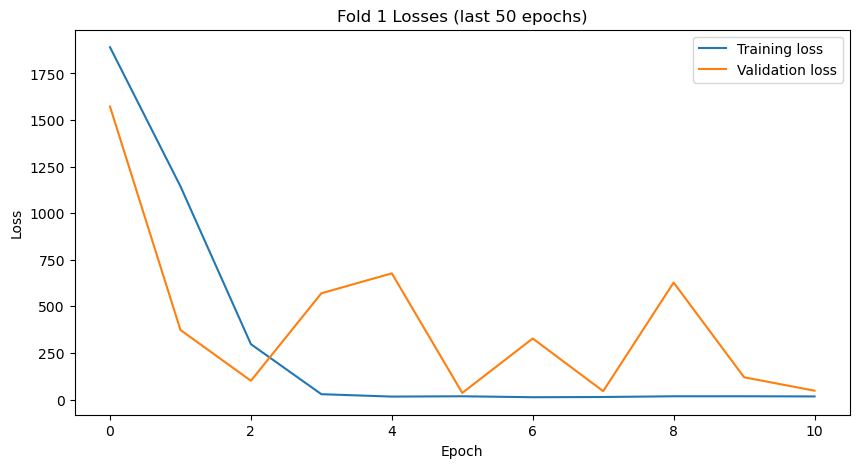

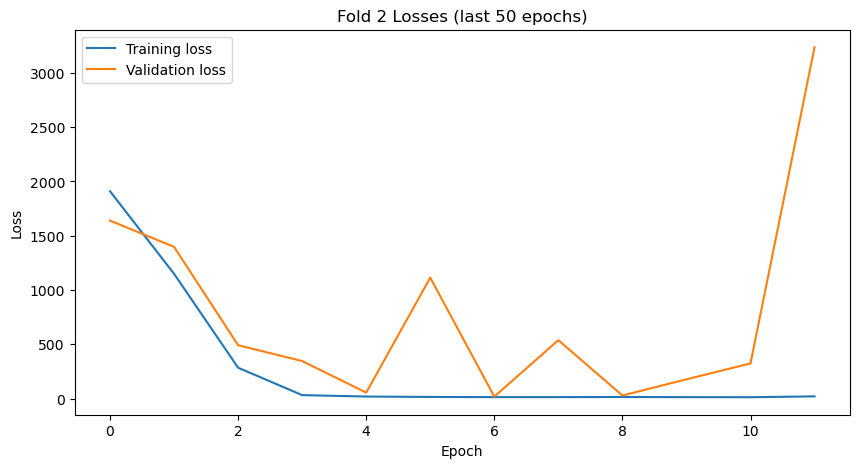

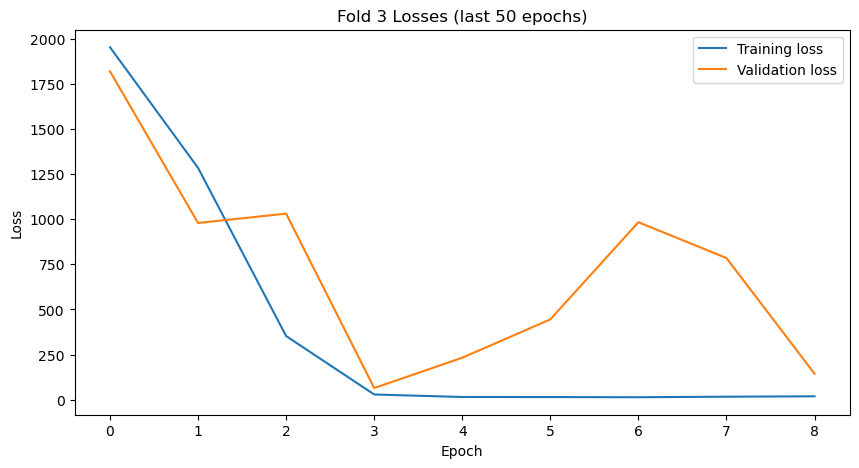

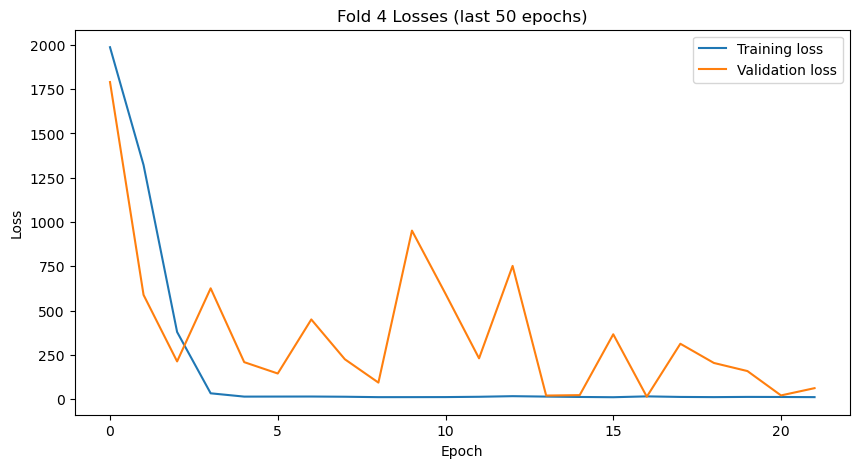

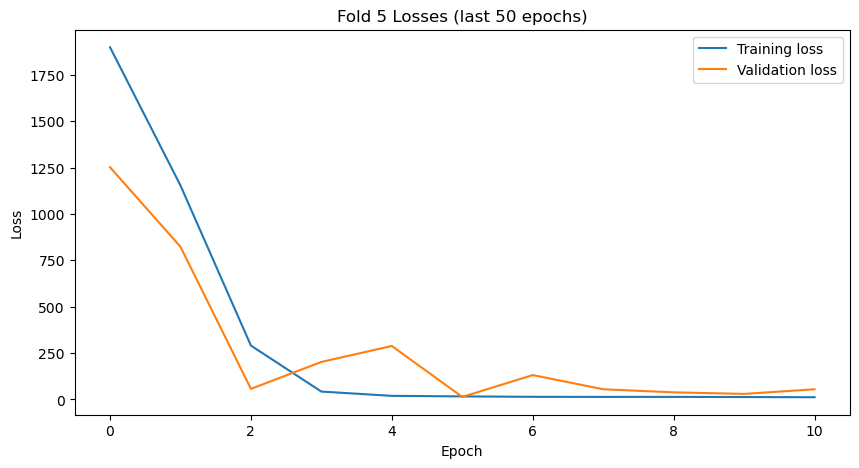

In [6]:
# function to plot the last n epochs train and test losses of each fold
def plot_last_n_epochs(train_los, val_los, n):
    for i in range(len(train_losses_all_folds)):
        train = train_los[i]
        val = val_los[i]
        
        plt.figure(figsize=(10, 5))
        plt.plot(train[-n:], label='Training loss')
        plt.plot(val[-n:], label='Validation loss')
        plt.title(f"Fold {i + 1} Losses (last {n} epochs)")
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()

plot_last_n_epochs(train_losses_all_folds, val_losses_all_folds, 50)

In [ ]:
# Function to reset weights and biases
def reset_weights(m):
    if hasattr(m, 'reset_parameters'):
        m.reset_parameters()

# Apply the reset function to each layer
model.apply(reset_weights)